In [1]:
import pandas as pd
from tabulate import tabulate
from IPython.display import HTML, display

tabulateDf = lambda df: tabulate(df, headers='keys', tablefmt='html', showindex='never')
tabulateMissingValuePercent = lambda df: tabulateDf(pd.DataFrame({'column_name': df.columns, 'percent_missing': df.isna().mean().round(4) * 100}))

airbnb_listing_df = pd.read_csv("listings.csv")
# Choosing relevant columns: Essentially removing all text columns except reviews
airbnb_relevant_df = airbnb_listing_df[["id", "zipcode","city", "state", "bedrooms", "square_feet", "price", "weekly_price", "monthly_price", "cleaning_fee", "neighbourhood_group_cleansed", "number_of_reviews", "review_scores_rating", "latitude", "longitude"]]
display(HTML(tabulateMissingValuePercent(airbnb_relevant_df)))


c:\Users\nikita\Desktop\data_analytics_material\P_Info\capitalone_project\venv\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (43,61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


column_name,percent_missing
id,0
zipcode,1.06
city,0.13
state,0.01
bedrooms,0.04
square_feet,99.17
price,0
weekly_price,87.72
monthly_price,89.27
cleaning_fee,21.77


In [2]:
# The table shows 1% missing values in zip code which is concerning. There are also missing values in city
# But there are no missing values in latitude and longitude
# Fortunately, there are no missing values in price(per night), number_of_reviews
# There are just 0.04% missing values in bedroom we will ignore those records

airbnb_relevant_df = airbnb_relevant_df[airbnb_relevant_df.bedrooms == 2]
print("States: {}".format(airbnb_relevant_df.state.unique()))
print("Zipcode: {}".format(airbnb_relevant_df.zipcode.unique()))

States: ['NY' 'Ny' nan]
Zipcode: ['10029' '11221' '11206' '10001' '10162' '11215' '10075' '11211' '10031'
 '10002' '11217' '11231' '11233' '10009' '10023' '11201' '11238' '11249'
 '10027' '10039' '11385' '10013' '10011' '11222' '11216' '10032' '11205'
 '10003' '10012' '10026' '10025' '10128' '10014' '11104' '10022' '11225'
 '11101' '10038' '11213' '11106' '10016' '10036' '10463' '10065' '10024'
 '10455' '10034' '11237' '10469' '11235' '10314' '10452' '11103' '11220'
 '10004' '11226' '10282' '10019' '11377' '10033' '10021' '11230' '11214'
 '10037' '10010' '11418' '10030' '10005' '10035' '11218' '11105' '11372'
 nan '11207' '10028' '10017' '11208' '10040' '11412' '11367' '11374'
 '11209' '11693' '10305' '11109' '10304' '11102' '11212' '11232' '11204'
 '10451' '11369' '11234' '10473' '10301' '10044' '10018' '11236' '11203'
 '11373' '10475' '11417' '10459' '10007' '11375' '10280' '10069' '11223'
 '11433' '10454' '11692' '11365' '10308' '11210' '11426' '11423' '11434'
 '11228' '10006' '1143

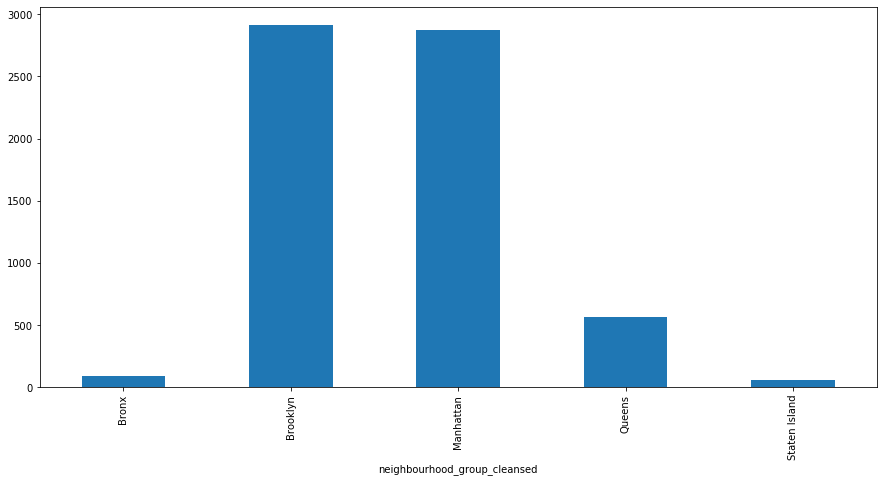

In [3]:
# Zip code values are also not consistent(Float and string along with different formats)
# Since there is no constant value for state of NY (NY, Ny, ny and New York),we can leverage lat, log values
# We can use latitude and longitude values to get zipcode and city for all records

import numpy as np
from uszipcode import SearchEngine

zipcodes = []
city = []
search = SearchEngine()
for idv in airbnb_relevant_df.id.values:
    zipcode_orig = airbnb_relevant_df.zipcode[airbnb_relevant_df.id == idv].values[0]
    lattitude_val = airbnb_relevant_df.latitude[airbnb_relevant_df.id == idv].values
    longitude_val = airbnb_relevant_df.longitude[airbnb_relevant_df.id == idv].values
    zipcode_result = search.by_coordinates(lat=float(lattitude_val), lng=float(longitude_val), radius=5.0, returns=1)
    city.append(zipcode_result[0].major_city)
    if pd.isnull(zipcode_orig) or (isinstance(zipcode_orig, str) and len(zipcode_orig) != 5):
        zipcodes.append(zipcode_result[0].zipcode)
    else:
        zipcodes.append(int(zipcode_orig))
    
airbnb_relevant_df['zipcode_cleansed'] = zipcodes
airbnb_relevant_df['city_cleansed'] = city

# Cleaning up price and cleaning_fee colum (Removing $ column and removing commas)
airbnb_clean_df = airbnb_relevant_df.copy()

# Removing dollar sign for price column
airbnb_clean_df.price = airbnb_clean_df.price.str.replace(',', '')
airbnb_clean_df.price = airbnb_clean_df.price.str.replace('$', '')
airbnb_clean_df.price = airbnb_clean_df.price.astype(float)

airbnb_clean_df.cleaning_fee = airbnb_clean_df.cleaning_fee.fillna('$0')
airbnb_clean_df.cleaning_fee = airbnb_clean_df.cleaning_fee.str.replace('$', '')
airbnb_clean_df.cleaning_fee = airbnb_clean_df.cleaning_fee.str.replace(',', '')
airbnb_clean_df.cleaning_fee = airbnb_clean_df.cleaning_fee.astype(float)

airbnb_clean_df.weekly_price = airbnb_clean_df.weekly_price.fillna('$0')
airbnb_clean_df.weekly_price = airbnb_clean_df.weekly_price.str.replace('$', '')
airbnb_clean_df.weekly_price = airbnb_clean_df.weekly_price.str.replace(',', '')
airbnb_clean_df.weekly_price = airbnb_clean_df.weekly_price.astype(float)

airbnb_clean_df.monthly_price = airbnb_clean_df.monthly_price.fillna('$0')
airbnb_clean_df.monthly_price = airbnb_clean_df.monthly_price.str.replace('$', '')
airbnb_clean_df.monthly_price = airbnb_clean_df.monthly_price.str.replace(',', '')
airbnb_clean_df.monthly_price = airbnb_clean_df.monthly_price.astype(float)

# Checking prices grouped by neighbourhood
from matplotlib import pyplot as plt
fig,ax = plt.subplots(figsize=(15, 7))
airbnb_clean_df.groupby('neighbourhood_group_cleansed').price.count().plot(kind='bar',ax=ax)

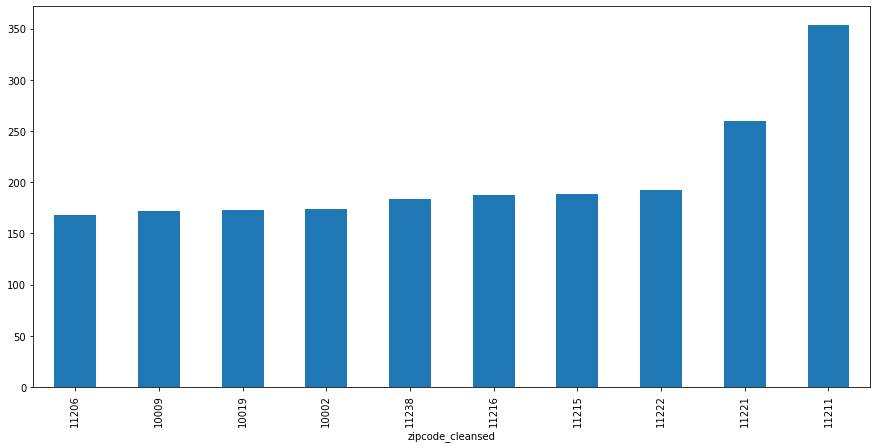

In [4]:
# From above table, it appears that Brooklyn, Manhattan and Queens are top 3 neighborhoods with most listings

# Top 10 zip codes where there are most listings
fig,ax = plt.subplots(figsize=(15, 7))
airbnb_clean_df.groupby('zipcode_cleansed').price.count().sort_values().tail(10).plot(kind='bar', ax=ax)

In [5]:
# Analyzing zillow data
zillow_df = pd.read_csv("Zip_Zhvi_2bedroom.csv")
zillow_ny_df = zillow_df[zillow_df.City=='New York']

from statsmodels.tsa.arima_model import ARIMA
# Since the data is from April,1996 to June,2017 with Nan values, we'll use last 10 years data
# Last 10 years data for New York doesn't have any Nan values
current_est_price = []
for i,row in zillow_ny_df.iterrows():
    prices = row[-121:]
    size = int(len(prices) * 0.66)

    train, test = prices[0: size], prices[size: len(prices)]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(5, 1, 0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        output
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)

    prediction = model_fit.predict(start=80, end=152, typ='levels')
    current_est_price.append(prediction[-1:].round(2))

zillow_relevant_df = zillow_ny_df.iloc[:, :7].copy()
zillow_relevant_df['current_est_price'] = current_est_price

airbnb_clean_relevant_df = airbnb_clean_df.drop(columns=['id', 'city', 'state', 'square_feet', 'latitude', 'longitude', 'city_cleansed'])
airbnb_clean_relevant_df = airbnb_clean_relevant_df.rename(columns={'zipcode': 'zipcode_orig', 'zipcode_cleansed': 'zipcode'})

zillow_relevant_df = zillow_relevant_df.drop(columns=['RegionID'])
zillow_relevant_df = zillow_relevant_df.rename(columns={'RegionName': 'zipcode'})

#  Merging zillow and airbnb dataset
combined_df = pd.merge(left=airbnb_clean_relevant_df, right=zillow_relevant_df, on='zipcode')
display(HTML(tabulateDf(combined_df.head())))

c:\Users\nikita\Desktop\data_analytics_material\P_Info\capitalone_project\venv\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


zipcode_orig,bedrooms,price,weekly_price,monthly_price,cleaning_fee,neighbourhood_group_cleansed,number_of_reviews,review_scores_rating,zipcode,City,State,Metro,CountyName,SizeRank,current_est_price
11215,2,225,0,0,0,Brooklyn,4,100,11215,New York,NY,New York,Kings,71,1.21503e+06
11215,2,400,2700,0,120,Brooklyn,16,95,11215,New York,NY,New York,Kings,71,1.21503e+06
11215,2,250,0,0,165,Brooklyn,80,94,11215,New York,NY,New York,Kings,71,1.21503e+06
11215,2,135,810,0,0,Brooklyn,21,97,11215,New York,NY,New York,Kings,71,1.21503e+06
11215,2,169,0,0,60,Brooklyn,398,97,11215,New York,NY,New York,Kings,71,1.21503e+06


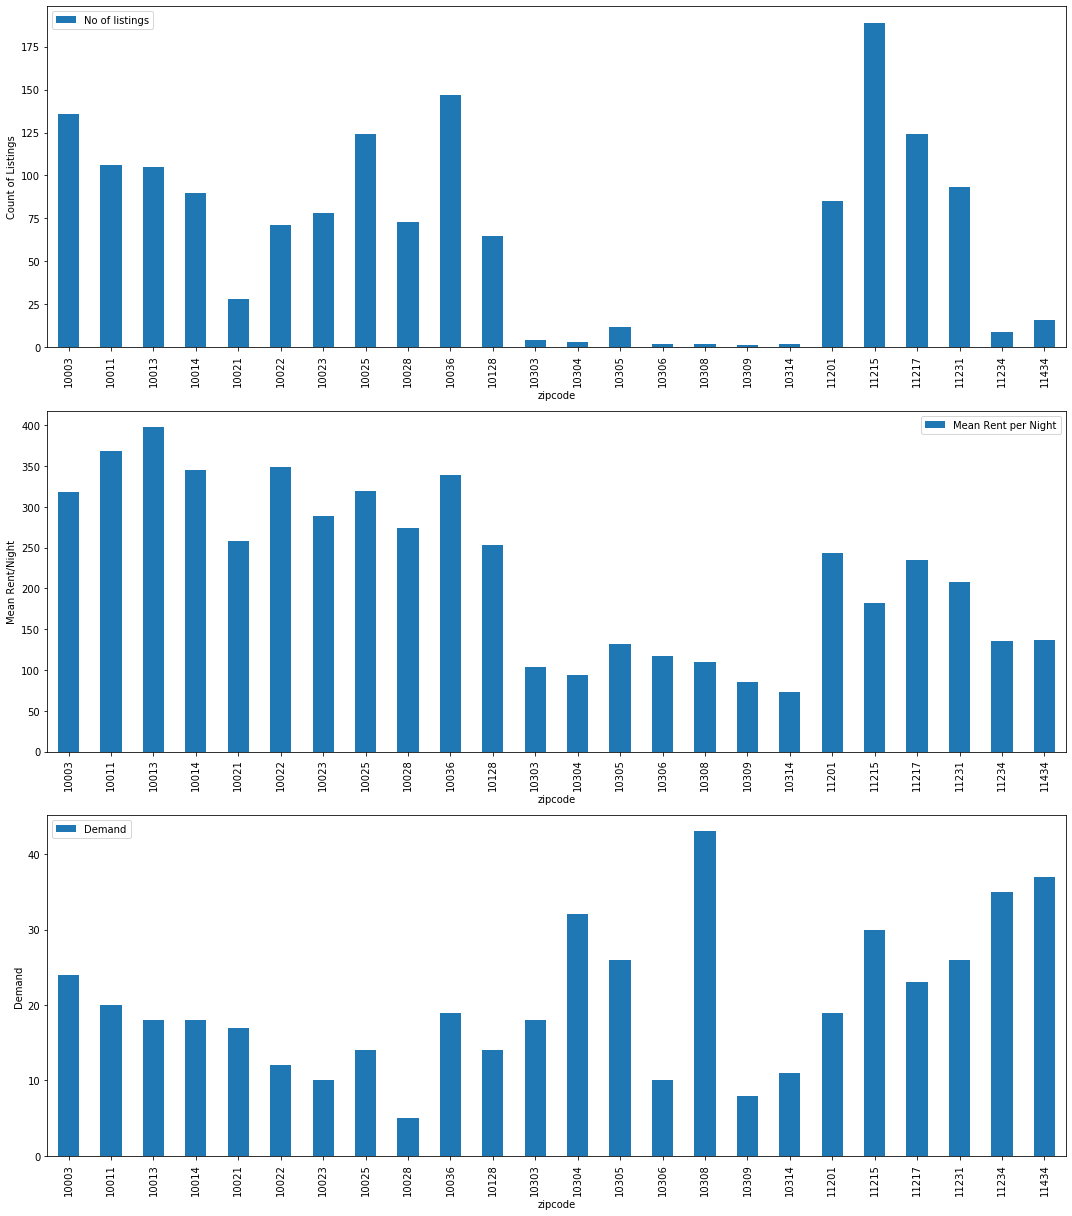

In [6]:
# Above table shows our dataframe to have multiple entries for same zip code, due to different prices and listings
# We'll shrink the table by
# 1. Taking mean of prices
# 2. Mean of Number of Reviews and Review Score Rating
# 3. Adding a column with total listings in the zipcode
# 4. For values that are same for given zip code (viz. city, county and current price), we'll pick the same value

combined_df.current_est_price = combined_df.current_est_price.astype(float)

def GroupBySeriesToSeries(grpBySeries):
    value = []
    key=[]
    for state, frame in grpBySeries:
        key.append(state)
        value.append(frame.values[0])

    series = pd.Series(data=value, index = key)
    return(series)

mean_bedrooms = combined_df.groupby('zipcode').bedrooms.mean().astype(int)
mean_price = combined_df.groupby('zipcode').price.mean().round(2)
mean_weekly_price = combined_df.groupby('zipcode').weekly_price.mean().round(2)
mean_monthly_price = combined_df.groupby('zipcode').monthly_price.mean().round(2)
mean_clean_fee = combined_df.groupby('zipcode').cleaning_fee.mean().round(2)
mean_neighbourhood_group_cleansed = GroupBySeriesToSeries(combined_df.groupby('zipcode').neighbourhood_group_cleansed)
mean_number_of_reviews = combined_df.groupby('zipcode').number_of_reviews.mean().round(0)
review_scores_rating = combined_df.groupby('zipcode').review_scores_rating.mean().round(0)
mean_city = GroupBySeriesToSeries(combined_df.groupby('zipcode').City)
mean_state = GroupBySeriesToSeries(combined_df.groupby('zipcode').State)
mean_metro = GroupBySeriesToSeries(combined_df.groupby('zipcode').Metro)
mean_county_name = GroupBySeriesToSeries(combined_df.groupby('zipcode').CountyName)
mean_current_price = combined_df.groupby('zipcode').current_est_price.mean().round(2)
num_of_listing = combined_df.groupby('zipcode').price.count()

clean_data_df = pd.DataFrame({
                                 'bedrooms': mean_bedrooms,
                                 'num_of_listing': num_of_listing,
                                 'price': mean_price,
                                 'weekly_price': mean_weekly_price,
                                 'monthly_price': mean_monthly_price,
                                 'cleaning_fee': mean_clean_fee,
                                 'neighbourhood_group_cleansed': mean_neighbourhood_group_cleansed,
                                 'number_of_reviews': mean_number_of_reviews,
                                 'review_score_rating': review_scores_rating,
                                 'city': mean_city,
                                 'state': mean_state,
                                 'metro': mean_metro,
                                 'county_name': mean_county_name,
                                 'current_price_est': mean_current_price
                                 })
clean_data_df = clean_data_df.reset_index()
clean_data_df = clean_data_df.rename(columns={'index':'zipcode'})

fig,(ax, ax1, ax2) = plt.subplots(3,figsize=(15, 17))
clean_data_df[['zipcode', 'num_of_listing']].plot(kind='bar', 
                                                  x='zipcode', 
                                                  y='num_of_listing', 
                                                  label='No of listings',
                                                  ax=ax)

clean_data_df[['zipcode', 'price']].plot(kind='bar', 
                                         x='zipcode', 
                                         y='price', 
                                         label='Mean Rent per Night',
                                         ax=ax1)

# Assuming rumber of reivews as demand
clean_data_df[['zipcode', 'number_of_reviews']].plot(kind='bar', 
                                                     x='zipcode', 
                                                     y='number_of_reviews', 
                                                     label="Demand",
                                                     ax=ax2)
ax.set_ylabel('Count of Listings')
ax1.set_ylabel('Mean Rent/Night')
ax2.set_ylabel('Demand')

ax.legend(loc='upper left')

ax2.legend(loc='upper left')


fig.tight_layout()
plt.show()

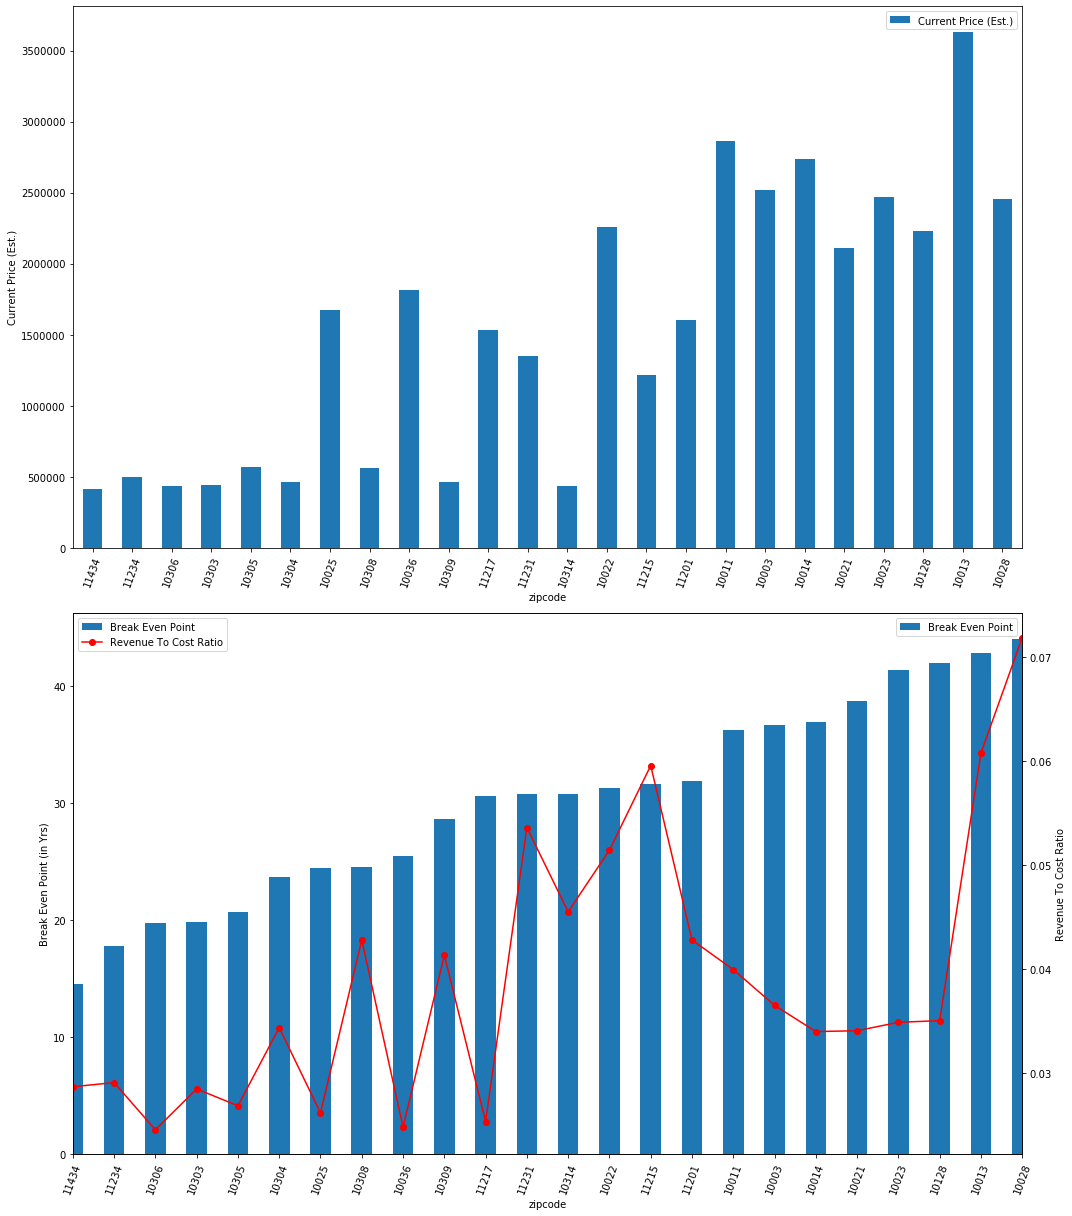

In [7]:
# Above graps shows, that 
# 1. Though 11215 has max listings, the price in that zipcode is not the highest, but decent demand
# 2. 10013 though has max price, there are only about 100 or so listings in the zipcode with low to moderate demand
# 3. 10308 though has max demand, there are low number of listings there with low prices

# Profit and Revenue Calculations

# Following fields are created to calculate revenue
daily_prob = 0.8      # Assumption 1: Probability of AirBnb booking is made for days less than a week
weekly_prob = 0.15    # Assumption 2: Probability of AirBnb booking made for a week
monthly_prob = 0.05   # Assumption 3: Probability of AirBnb booking made for a month
occupancy_rate = 0.75 # Given: Probability that the property is booked on any given day

# Assumption: Cleaning fee is paid weekly by the owner of the property

# Following values will be calculated
# Revenue_Annual(est.) = occupancy_rate * 365 * ((daily_prob X rent_per_day)+(weekly_prod x Rent_per_Week/7)+(monthly_prod x Rent_per_Month/30))
# Revenue_to_Cost ratio = Revenue_Annual / Est_Cost
# Breakeven Point = Est_Cost / (Revenue_Annual - (occupancy_rate * 52 * cleaning_fee))
# N_Year_Est(Net) = (Revenue_Annual - (occupany_rate * 52 * cleaning_fee)) * N - Est_Cost

clean_data_df['annual_revenue_est'] = 0.75 * 365 * ((daily_prob * clean_data_df['price']) + 
                                                    (weekly_prob * clean_data_df['weekly_price']/7)+
                                                    (monthly_prob * clean_data_df['monthly_price']/30))

clean_data_df['revenue_to_cost'] = clean_data_df['annual_revenue_est'] / clean_data_df['current_price_est']

net_revenue_annual = clean_data_df['annual_revenue_est'] - (occupancy_rate * 52 * clean_data_df['cleaning_fee'])

clean_data_df['break_even_pt'] = clean_data_df['current_price_est'] / net_revenue_annual

clean_data_df['5_yr_net_est'] = net_revenue_annual * 5 - clean_data_df['current_price_est']
clean_data_df['15_yr_net_est'] = net_revenue_annual * 15 - clean_data_df['current_price_est']
clean_data_df['20_yr_net_est'] = net_revenue_annual * 20 - clean_data_df['current_price_est']
clean_data_df['25_yr_net_est'] = net_revenue_annual * 25 - clean_data_df['current_price_est']

# In order to find the best zipcodes to invest, we desire zipcodes with:
# 1. Least Break Even Point
# 2. Higher Revenue to Cost ratio
# 3. Low Purchase Cost

fig,(ax, ax1) = plt.subplots(2, figsize=(15, 17))

clean_data_df.sort_values(by=['break_even_pt']).plot(kind='bar',
                                                     x='zipcode', 
                                                     y='current_price_est', 
                                                     label='Current Price (Est.)',
                                                     ax=ax)

clean_data_df.sort_values(by=['break_even_pt']).plot(kind='bar',
                                                     x='zipcode', 
                                                     y='break_even_pt', 
                                                     label='Break Even Point',
                                                     ax=ax1)
ax_y = clean_data_df['revenue_to_cost'].plot(secondary_y=True,
                                      color='red', 
                                      label='Revenue To Cost Ratio',
                                      marker='o')

ax.set_ylabel('Current Price (Est.)')
ax1.set_ylabel('Break Even Point (in Yrs)')
ax_y.set_ylabel('Revenue To Cost Ratio')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=70)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=70)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax_y.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=2)

fig.tight_layout()
plt.show()

# From the graphs, top 3 zip codes to invest would be: 
# 1. 11215 (Brooklyn)
# 2. 11231 (Brooklyn)
# 3. 10308 (Staten Island)

#  zipcode 10028(Manhattan) has high revenue to cost ratio and relatively lower price range. However, the break even point is 
#  higher (More than 40 years)
 